In [0]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, RepeatedKFold, ShuffleSplit
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import Lasso
from sklearn.svm import NuSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import *
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

In [2]:
house = fetch_california_housing()

In [0]:
pd.set_option("display.width", 70)

In [0]:
def make_dataframe(ds_function):
    ds = ds_function()
    df = pd.DataFrame(data = np.c_[ds['data'], ds['target']], columns = list(ds['feature_names']) + ['target'])
    return df

In [5]:
temp_df = make_dataframe(fetch_california_housing)
temp_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [6]:
temp_df.dtypes

MedInc        float64
HouseAge      float64
AveRooms      float64
AveBedrms     float64
Population    float64
AveOccup      float64
Latitude      float64
Longitude     float64
target        float64
dtype: object

In [7]:
temp_df.shape

(20640, 9)

In [8]:
temp_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [9]:
temp_df.isnull().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
target        0
dtype: int64

In [0]:
X, y  = fetch_california_housing(return_X_y = True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [11]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(15480, 8)
(5160, 8)
(15480,)
(5160,)


In [0]:
def test_model(model):
    print("mean_absolute_error:", mean_absolute_error(y_test, model.predict(X_test)))
    print("median_absolute_error:", median_absolute_error(y_test, model.predict(X_test)))
    print("r2_score:", r2_score(y_test, model.predict(X_test)))

In [13]:
las_1 = Lasso(alpha=1.0)
las_1.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [15]:
test_model(las_1)

mean_absolute_error: 0.7687270988960121
median_absolute_error: 0.6624607842666271
r2_score: 0.28490402733386144


In [16]:
nusvr_05 = NuSVR(nu = 0.5, gamma='scale')
nusvr_05.fit(X_train, y_train)

NuSVR(C=1.0, cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.5, shrinking=True, tol=0.001, verbose=False)

In [17]:
test_model(nusvr_05)

mean_absolute_error: 0.8779879230587557
median_absolute_error: 0.7186568958438212
r2_score: 0.011233994620228005


In [21]:
dt_none = DecisionTreeRegressor(max_depth=None)
dt_none.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [22]:
test_model(dt_none)

mean_absolute_error: 0.47232441411498716
median_absolute_error: 0.26900000000000013
r2_score: 0.5804554528379742


In [0]:
def stat_tree(estimator):
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right

    node_depth = np.zeros(shape = n_nodes, dtype = np.int64)
    is_leaves = np.zeros(shape = n_nodes, dtype = bool)
    stack = [(0, -1)]
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    print("Всего узлов: ", n_nodes)
    print("Листовых узлов: ", sum(is_leaves))
    print("Глубина дерева: ", max(node_depth))
    print("Минимальная глубина листьев дерева: ", min(node_depth[is_leaves]))
    print("Средняя глубина листьев дерева: ", node_depth[is_leaves].mean())

In [34]:
stat_tree(dt_none)

Всего узлов:  29563
Листовых узлов:  14782
Глубина дерева:  36
Минимальная глубина листьев дерева:  6
Средняя глубина листьев дерева:  18.254228115275335


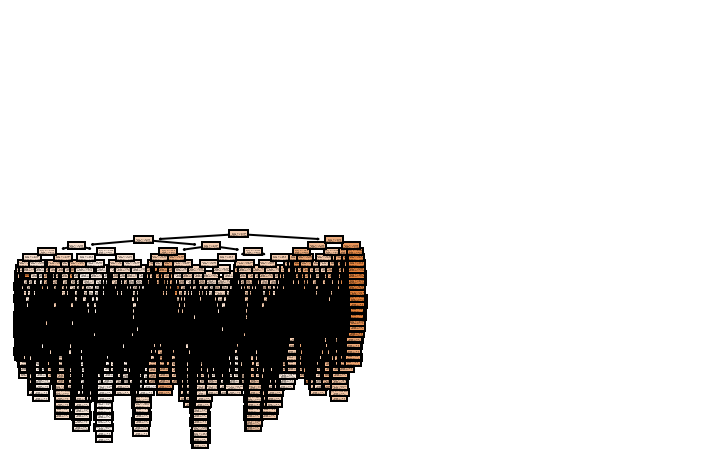

In [36]:
plot_tree(dt_none, filled = True);